<a href="https://colab.research.google.com/github/mcgrammar86/LOPL_YA_Diversity_Audit/blob/main/YA_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello! Before exploring this notebook, please hit Ctrl+F9 to run the code. This will reimport everything and load the contents into a live session.

# Importing and Cleaning the Audit Data

**The cells below import the required python modules and set some defaults for our graphing utility.**

In [1]:
!matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.color'] = 'lightgray'

/bin/bash: matplotlib: command not found


**This imports our dataset.**

In [2]:
audit_df = pd.read_csv('https://raw.githubusercontent.com/mcgrammar86/LOPL_YA_Diversity_Audit/main/YAFIC%20Diversity%20Audit.csv')


**Let's start by having a quick look at the first 5 rows of our data to make sure it's imported correctly.**

In [3]:
audit_df.head()

,Author,Item Barcode,Catalog Title,Total Charges,Item Created Date,Black,Asian,Latinx,Indigenous,White,Pacific Islander/Native Hawaiian,Refugee/Immigrant,Gender Roles,LGBTQ+,Family Structure,Adoption/Foster,Homeless,Socio-Economic,Ability Diverse,Neurodiversity,Mental Illness,Health Concerns,Culture/Religion,Judaism,Islam/Muslim,Hinduism,Own Voices
0,"YA-GARCIA, KAMI",54858717.0,Beautiful darkness /,29.0,8/13/2013,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
1,"YA-ABAWI, ATIA",55986129.0,The secret sky /,10.0,8/28/2014,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x,NaN,x
2,"YA-ABAWI, ATIA",70010731.0,A land of permanent goodbyes /,9.0,1/30/2018,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x
3,"YA-ABBOTT, TONY",70471990.0,Junk Boy,0.0,10/20/2020,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"YA-ABDEL-FATTAH, RANDA",46381760.0,Does my head look big in this? /,98.0,5/25/2007,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x,NaN,x


**No need for the "YA-" before the author's name, or the slash at the end of the book titles. Let's remove them.**

In [4]:
audit_df['Author'] = audit_df['Author'].str.replace('YA-','')
audit_df['Catalog Title'] = audit_df['Catalog Title'].str.replace(' /','')

**We find that there are 5 basic cataloging datapoints, along with 22 categories being tracked by the diversity audit. The categories are not encoded as True/False values, but are given as either an "x" to mark that category's presence within a work, or a missing value in its absence. Let's convert those to boolean values.**

In [5]:
audit_columns = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White',
       'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'Gender Roles',
       'LGBTQ+', 'Family Structure', 'Adoption/Foster', 'Homeless',
       'Socio-Economic', 'Ability Diverse', 'Neurodiversity', 'Mental Illness',
       'Health Concerns', 'Culture/Religion', 'Judaism', 'Islam/Muslim',
       'Hinduism', 'Own Voices']

for col in audit_columns:
  audit_df[col] = (audit_df[col] == 'x')

**Let's add up the number of categories present for each title to create a rough "diversity score" metric, then examine the distribution of diversity scores across the collection.**

In [6]:
audit_df['diversity_score'] = audit_df[audit_columns].sum(axis=1)
audit_df['diversity_score'].value_counts().sort_index()

0      76
1     923
2     550
3     353
4     199
5     119
6      39
7      15
8       4
9       4
10      1
12      1
Name: diversity_score, dtype: int64

**There are 76 titles with no diversities category checked off. This seems unusual. Let's look at what titles are present.**

In [7]:
audit_df.loc[audit_df['diversity_score']==0, 'Catalog Title'].values

array(['Speak', 'The assassination of Brangwain Spurge', 'Alone',
       'King of scars', 'Siege and storm', 'Crooked kingdom',
       'Ruin and rising', 'Frozen', 'Being Nikki', 'Honor among thieves',
       'Paper and fire', 'Sun warrior', 'Hunted', 'The go-between',
       'Caster', 'The wizard heir', 'The sorcerer heir',
       'Ready player one', 'Catching fire', '29 dates', 'Pet',
       'If I stay', 'How (not) to ask a boy to prom', 'Eve & Adam',
       'Front lines', 'BZRK', 'BZRK reloaded', 'Lost stars',
       'Shadow scale', 'The body in the woods', 'The courage of Elfina',
       'Truly devious', 'The story of Owen : dragon slayer of Trondheim',
       'To kill a mockingbird', 'Strange relations', 'We were liars',
       'The power of Six', 'Queen of shadows', 'Nameless queen',
       'Soundless', 'Fireborne', 'Dairy queen', 'Before I fall',
       'Animal farm : a fairy story', 'Eragon', 'Tales from Alagaësia.',
       'Eldest', 'The angel experiment', 'Maximum Ride foreve

**Some of these titles, such as "To Kill A Mockingbird" would likely have at least one category marked as present. Many might be fantasy, but with no further information available, it is unclear if the absence of any diversity category is correct. Let's export a copy of these titles to provide to the library for further inquiry.**

In [8]:
audit_df.loc[audit_df['diversity_score']==0, ['Author', 'Catalog Title','Item Barcode']].to_csv('diversity_audit_no_data.csv')

**For now, let's remove titles with no diversity categories present until we get further information.**

In [9]:
audit_df = audit_df[audit_df['diversity_score'] > 0]

**Lastly, let's check to be sure there are no duplicate entries.**

In [10]:
print("There are {} entries in the dataframe.".format(audit_df.shape[0]))
print("There are {} unique title/author combinations in the dataframe.".format(audit_df[['Author','Catalog Title']].agg(' '.join,axis=1).nunique()))

There are 2208 entries in the dataframe.
There are 2192 unique title/author combinations in the dataframe.


**It looks like we have some duplicate titles, but this might just be a coincidence. Let's group the entries by title and Author, combine the diversity category columns, keep the earliest entry, and add up the total number of checkouts.**

In [11]:
authors_and_titles = audit_df.groupby(['Catalog Title', 'Author'])
div_categories = authors_and_titles[audit_columns].max()
earliest_item = authors_and_titles['Item Created Date'].min()
earliest_item = authors_and_titles['Item Created Date'].min()
charges = authors_and_titles['Total Charges'].sum()
new_df = pd.concat([earliest_item, charges, div_categories], axis=1)
new_df['diversity_score'] = new_df[audit_columns].sum(axis=1)
audit_df = new_df.reset_index()

**And checking again for duplicates.**

In [12]:
print("There are {} entries in the dataframe.".format(audit_df.shape[0]))
print("There are {} unique title/author combinations in the dataframe.".format(audit_df[['Author','Catalog Title']].agg(' '.join,axis=1).nunique()))

There are 2192 entries in the dataframe.
There are 2192 unique title/author combinations in the dataframe.


# Diversity Category Prevelance

**Now that we have a cleaned dataset, we can examine the relative frequency of each diversity category's presence within the collection.**

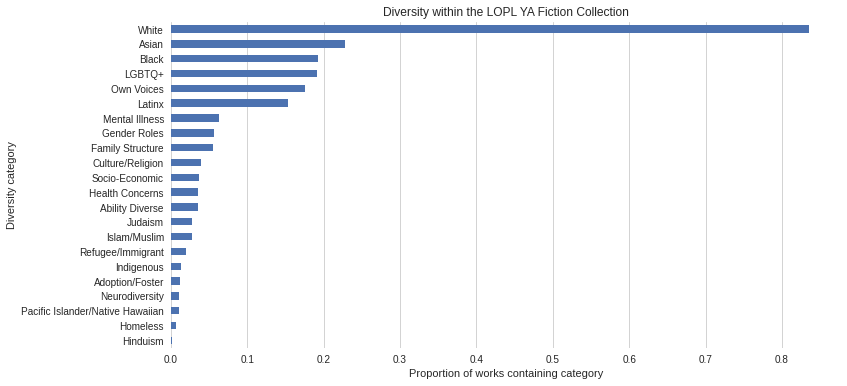

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.grid(axis='x')
plt.show()

**Works featuring white charaters or white perspectives feature very heavily - about 80% of the collection. We can zoom in on the other categories for a clearer look at them.**

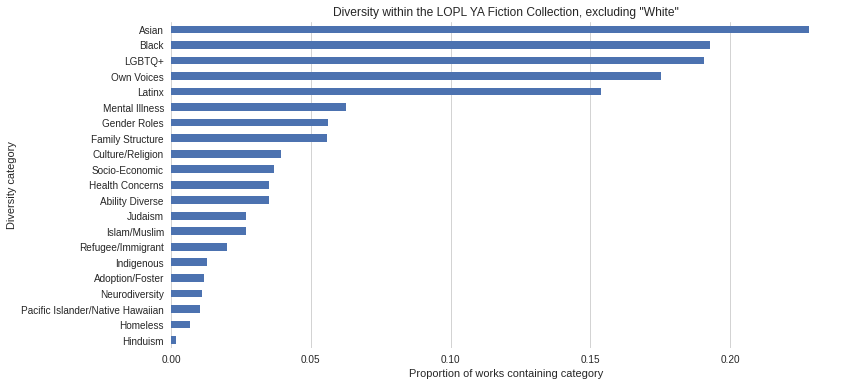

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].drop('White',axis=1).mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection, excluding "White"')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.grid(axis='x')
plt.show()

# Importing Census Data

**Ideally, we'd like to look not just at the composition of the collection itself, but also how this composition compares to that of the broader community of Lake Oswego. Let's pull data from the US Census Bureau's 2019 American Community Survey to get a clearer sense of community demographics.**

In [15]:
%%capture
!pip install censusdata
import censusdata

In [16]:
lake_oswego_geocode = censusdata.censusgeo([('state', '41'), ('place', '40550')])

In [17]:
# this is all ages, but it's possible to limit to specific age brackets: 10-14, 15-17, 18-19, 20, 21
race_table_metadata = censusdata.censustable('acs5', 2019, 'B02001')
race_table_vars = list(race_table_metadata.keys())[:6]
race_table = censusdata.download('acs5', 2019, lake_oswego_geocode, race_table_vars)


In [18]:
race_table_columns = ['Total','White','Black','Indigenous','Asian','Pacific Islander/Native Hawaiian']
race_table.columns = race_table_columns
race_table.reset_index(inplace=True, drop=True)
race_table

,Total,White,Black,Indigenous,Asian,Pacific Islander/Native Hawaiian
0,39127,33567,405,286,2404,173


In [19]:
lake_oswego_population = race_table.loc[0,'Total']
proportions_table = race_table / lake_oswego_population
proportions_table = proportions_table.drop('Total', axis=1)

In [20]:
hispanic_table_metadata = censusdata.censustable('acs5', 2019, 'B03001')
hispanic_table_vars = list(hispanic_table_metadata.keys())[:3]
hispanic_table = censusdata.download('acs5', 2019, lake_oswego_geocode, hispanic_table_vars)

In [21]:
hispanic_table.columns = ['Total','Not Hispanic or Latino', 'Hispanic or Latino']
hispanic_table.reset_index(inplace=True, drop=True)
hispanic_proportion = hispanic_table.loc[0,'Hispanic or Latino'] / hispanic_table.loc[0,'Total']

proportions_table['Latinx'] = hispanic_proportion

In [22]:
immigration_table_info = censusdata.censustable('acs5', 2019, 'B05002')

immigrant_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B05002_009E'])
immigrant_table.reset_index(inplace=True, drop=True)
immigrant_proportion = (immigrant_table.loc[0,'B05002_009E'] / lake_oswego_population)

proportions_table['Refugee/Immigrant'] = immigrant_proportion

In [23]:
neurodiversity_table_info = censusdata.censustable('acs5', 2019, 'B18104')
neurodiversity_table_info
neurodiversity_vars = ['B18104_004E', 'B18104_007E','B18104_010E','B18104_013E','B18104_016E', 'B18104_020E','B18104_023E','B18104_026E','B18104_029E','B18104_032E']
neurodiversity_table = censusdata.download('acs5', 2019, lake_oswego_geocode, neurodiversity_vars)
neurodiverse_population = neurodiversity_table.values.sum()
neurodiverse_proportion = neurodiverse_population / lake_oswego_population
proportions_table['Neurodiversity'] = neurodiverse_proportion

In [24]:
# Should this be limited to specific age range?

ability_table_info = censusdata.censustable('acs5', 2019, 'B18101')
ability_table_info
ability_vars = ['B18101_004E', 'B18101_007E','B18101_010E','B18101_013E','B18101_016E', 'B18101_019E','B18101_023E','B18101_026E','B18101_029E','B18101_032E', 'B18101_035E', 'B18101_038E']
ability_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ability_vars)
ability_population = ability_table.values.sum()
ability_proportion = ability_population / lake_oswego_population
proportions_table['Ability Diverse'] = ability_proportion

In [25]:
adopted_children = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B09019_016E']).values
proportions_table['Adoption/Foster'] = adopted_children / lake_oswego_population

In [26]:
# According to the Williams Institute, approximately 5.6% of Oregon's population identifies as LGBTQ+
proportions_table['LGBTQ+'] = 0.056

In [27]:
proportions_table.index=['LOPL Census']
proportions_table = proportions_table.T

In [28]:
cols = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White', 'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'LGBTQ+', 'Neurodiversity','Ability Diverse','Adoption/Foster']
collection_proportions = pd.DataFrame(audit_df[cols].mean(axis=0).sort_values(ascending=False))
collection_proportions.columns = ['LOPL YA Collection']
ratios_df = pd.concat([collection_proportions, proportions_table], axis=1)

**Now that we have the data gathered, let's look at the demographic makeup of Lake Oswego.**

In [29]:
ratios_df['LOPL Census'].sort_values() * 100

Pacific Islander/Native Hawaiian     0.442150
Adoption/Foster                      0.649168
Indigenous                           0.730953
Black                                1.035091
Refugee/Immigrant                    2.019066
Neurodiversity                       3.084826
Latinx                               5.175454
LGBTQ+                               5.600000
Asian                                6.144095
Ability Diverse                      7.833465
White                               85.789864
Name: LOPL Census, dtype: float64

# Diversity in the LOPL YA Collection compared to available Census Data

**Lake Oswego is predominantly white, much like the Portland metro area and Oregon as whole. Now that we have a good handle on the demographic makeup of the city, let's compare the census data and the collection data side-by-side.**

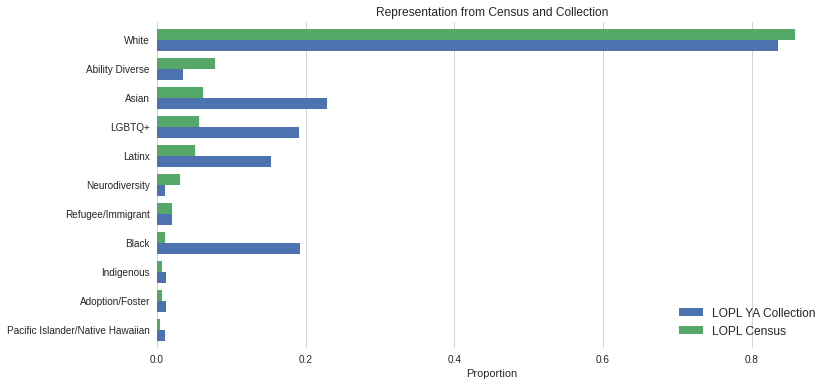

In [30]:
ratios_df[['LOPL YA Collection','LOPL Census']].sort_values('LOPL Census').plot.barh(figsize=(12,6), width=.75)
plt.legend(fontsize=12, loc='lower right')
plt.title('Representation from Census and Collection')
plt.xlabel('Proportion')
plt.grid(axis='x')
plt.show()

**As before, we can remove the "White" category from the visualization to get a closer look at the other categories.**

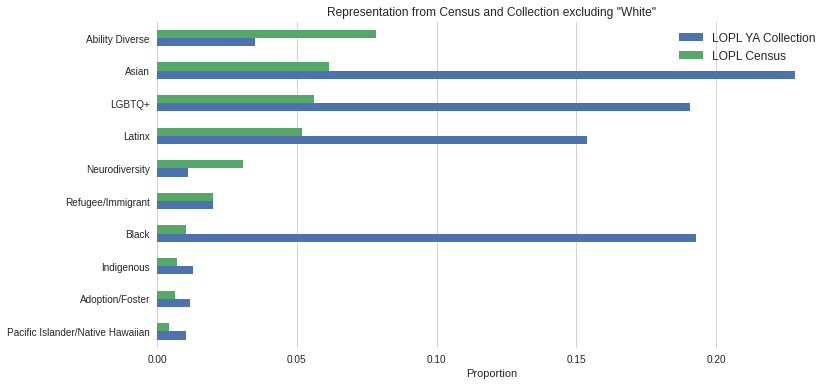

In [31]:
ratios_df[['LOPL YA Collection','LOPL Census']].drop('White',axis=0).sort_values('LOPL Census').plot.barh(figsize=(12,6))
plt.legend(fontsize=12)
plt.title('Representation from Census and Collection excluding "White"')
plt.xlabel('Proportion')
plt.grid(axis='x')
plt.show()

**We can see in the table above that there's a wide range of bar length variation between the census data and the collection itself. If we compare the length of these bars, we can produce a rough metric of how over/underrepresented various populations or topics are within the collection.**

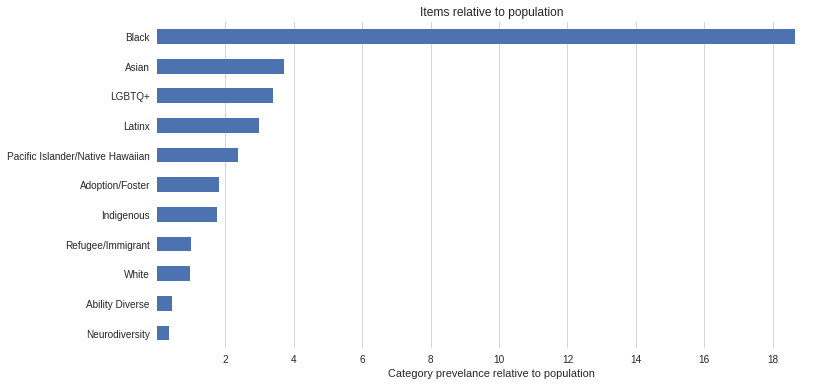

In [32]:
ratios_df['representation_ratio'] = ratios_df['LOPL YA Collection'] / ratios_df['LOPL Census']
ratios_df['representation_ratio'].sort_values().plot.barh(figsize=(12,6))
plt.xticks(range(2,20,2))
plt.title('Items relative to population')
plt.xlabel('Category prevelance relative to population')
plt.grid(axis='x')
plt.show()


# Popularity of diversity categories

**How popular is each topic? We can look at circulation information for each topic to learn more.**

In [90]:
melted = audit_df.melt(id_vars=['Total Charges'], value_vars=audit_columns, var_name='Diversity Category')
melted = melted[melted['value']].drop('value', axis=1)
charges_df = melted.pivot_table(index='Diversity Category', values='Total Charges', aggfunc=[np.mean, np.median, np.sum])
charges_df.columns = ['mean', 'median','sum']
charges_df = charges_df.sort_values('mean')

**The chart below can help visualize the relative popularity of different topics. The green bars show the average number of checkouts for books that contain each topic. Blue bars represent thae median number of checkouts for titles that contain each category. The greater the difference in the length of these bars, the more each topic's checkouts are dominated by a small number of titles.**

***Please note - there is a hidden bias in viewing the data in this way. Older titles that are still in the collection are less diverse and have had longer to circulate. Additionally, they have remained in the collection in part due to their strong circulation. I will attempt to account for this later.***

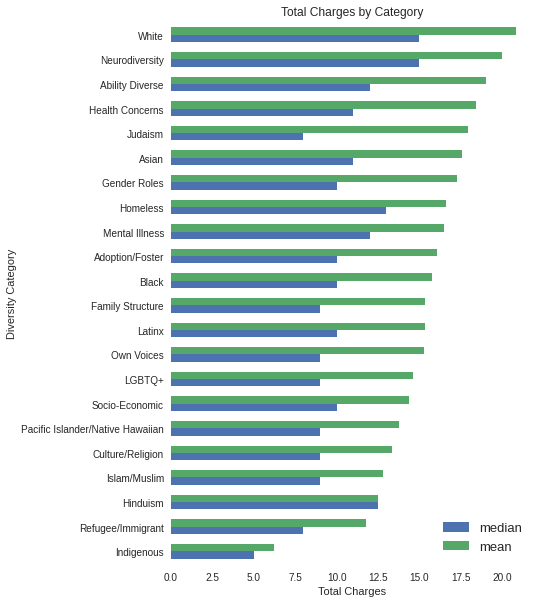

In [34]:
charges_df[['median','mean']].plot.barh(legend=False, figsize=(6.5,10), width=.6)
plt.title('Total Charges by Category')
plt.xlabel('Total Charges')
plt.legend(loc='lower right', fontsize=13)
plt.show()

# Own Voices analysis

**Own voices titles help to inform readers of the experiences of others, told from their own perspective. It's important to have titles in the collection which reflect the authentic voices of people who have lived the experiences that are being written about. To that end, how many titles in the LOPL YA collection are own voices?**

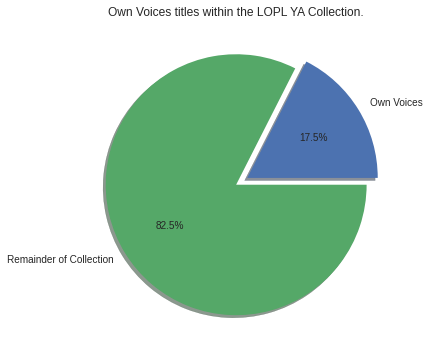

There are 384 Own Voices titles in the LOPL YA collection.


In [88]:

num_titles = audit_df.shape[0]
own_voices_titles = audit_df['Own Voices'].sum()
non_ov_titles = num_titles - own_voices_titles
fig = plt.figure(figsize=(6,6))

plt.pie([own_voices_titles, non_ov_titles], 
        labels=['Own Voices', 'Remainder of Collection'], 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=0,
        explode = [0.1,0])
plt.title('Own Voices titles within the LOPL YA Collection.')
plt.show()

print("There are {} Own Voices titles in the LOPL YA collection.".format(audit_df['Own Voices'].sum()))

**The LOPL YA Collection has 384 Own Voices titles, which make up about 17.5% of the collection. When did the library purchase these titles?**

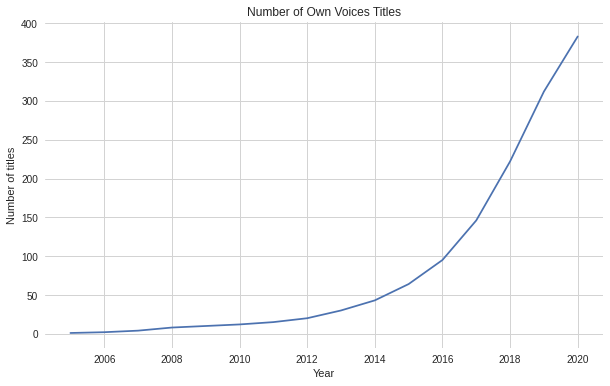

In [89]:
fig = plt.figure(figsize=(10,6))
ov_by_year = audit_df[audit_df['Own Voices']].groupby('Item Added Year')['Own Voices'].agg(['count']).cumsum()
plt.plot(ov_by_year)
plt.title('Number of Own Voices Titles')
plt.xlabel('Year')
plt.grid()
plt.ylabel('Number of titles')
plt.show()

In [38]:
ov_df  = pd.DataFrame.from_dict(ov_dict, orient='index', columns=['Average Charges','Total'])

**As we can see above, the LOPL YA collection has added a large number of Own Voices titles, particularly in the past five years. How are these titles distributed among the different diversity categories?**

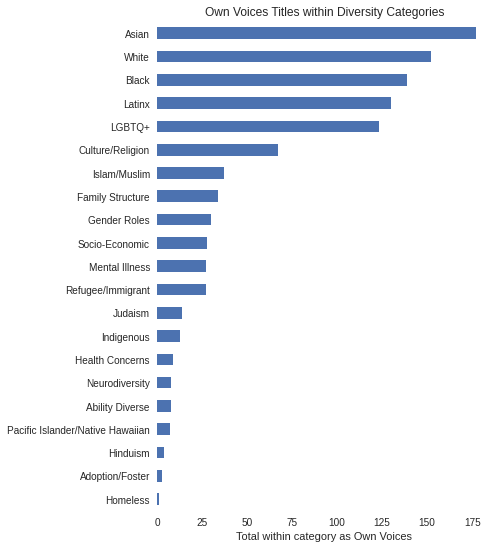

In [40]:
ov_df.sort_values('Total').plot.barh(y='Total',figsize=(6,9), legend=False)
plt.title('Own Voices Titles within Diversity Categories')
plt.xlabel('Total within category as Own Voices')
plt.show()

**What proportion of the works featuring each diversity category are own voices?**

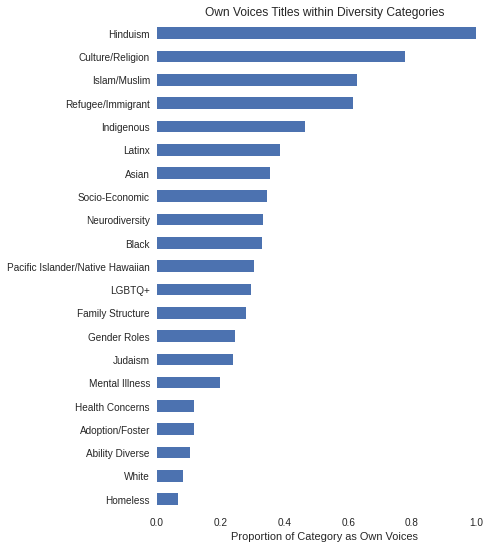

In [39]:
ov_df.sort_values('Average Charges').plot.barh(y='Average Charges',figsize=(6,9), legend=False)
plt.title('Own Voices Titles within Diversity Categories')
plt.xlabel('Proportion of Category as Own Voices')
plt.show()

# Trends over time

**In this secton, I'll explore ways to quantify the diversity of the collection and examine trends over time. I have not found a simple or reliable way to do this and feel the library's input would be valuable here. There's a good room for subjectivity on what diversity is within the context of this collection.**

**How has the diversity of the collection varied over time? Let's look at the raw average number of diversity categories present for titles added in each year.**

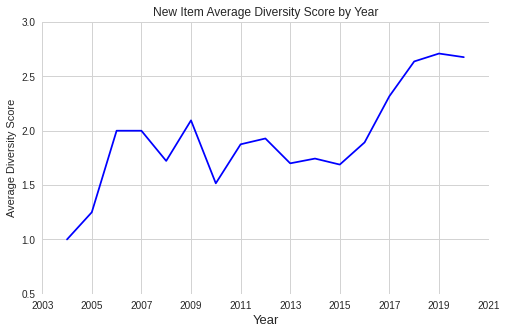

In [42]:
audit_df['Item Created Date'] = pd.to_datetime(audit_df['Item Created Date'])
audit_df['Item Added Year'] = audit_df['Item Created Date'].apply(lambda x: x.year)
diversity_by_year = audit_df.groupby('Item Added Year')['diversity_score'].agg(['mean'])

fig, ax = plt.subplots(figsize=(8,5))
diversity_by_year = diversity_by_year[diversity_by_year.index > 2003]

plt.plot(diversity_by_year.index, diversity_by_year, color='blue')
plt.title('New Item Average Diversity Score by Year')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Average Diversity Score')
plt.yticks([.5,1,1.5,2,2.5,3])
plt.xticks(range(2003,2022,2))
plt.grid()
plt.show()

**Simply counting the raw number of diveristy categories represented in titles can tell an incomplete picture. For example, an increase in titles featuring the same three categories would cause the graph above to show an upward trend. We want to look more comprehensively at the diversity of the titles and compute a metric that can capture both the breadth of topics in the collection, as well as the evenness with which those categories are represented. We can create a "code" for each unique combination of diversity categories, and then apply the forumla below to create this diversity metric. We'll be using Shannon's Diversity Index. https://en.wikipedia.org/wiki/Diversity_index**

$ $

$H' = \frac{N\ln N - \sum_{}(n_{i}\ln n_{i})}{N}$



Where $N$ is the total number of books, and $n_{i}$ is the number of books in each category.


In [43]:
audit_df['code'] = audit_df[audit_columns].astype(int).astype(str).agg(''.join, axis=1)
codes_by_year = audit_df.groupby('Item Added Year')['code'].value_counts()

print('Example Codes:')
print(audit_df['code'].head().values)

Example Codes:
['0010100000000000000000' '0000100010000000000000'
 '0100000010000000010101' '0000100000000100100000'
 '0000100000000000000000']


In [44]:
div_by_year = []

# calculate Shannon Diversity Score. 
for year in codes_by_year.index.levels[0]:
  year_values = codes_by_year[year].sort_values(ascending=False).values
  year_values = year_values[year_values>0]
  log_year_values = np.log(year_values)
  N = year_values.sum()
  shannon_H = (N * np.log(N) - (year_values * log_year_values).sum())/N
  div_by_year.append(shannon_H)

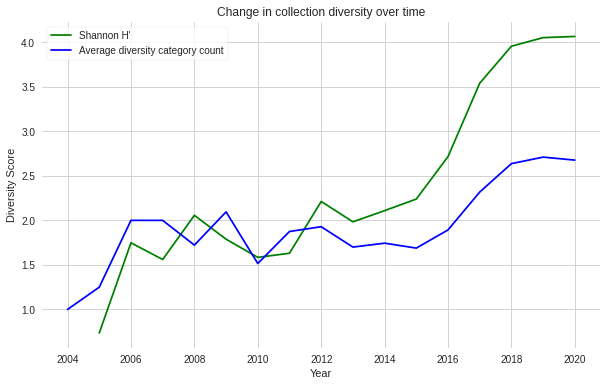

In [45]:
fig = plt.figure(figsize=(10,6))

plt.plot(codes_by_year.index.levels[0][2:], div_by_year[2:], label='Shannon H\'', color='green')
plt.plot(diversity_by_year.index, diversity_by_year, label='Average diversity category count', color='blue')
plt.legend(loc='upper left', facecolor='w', frameon=True)
plt.title('Change in collection diversity over time')
plt.xlabel('Year')
plt.ylabel('Diversity Score')
plt.grid()
plt.show()

**As we can see, the simple average of diversity categories underrepresents the true increase in the diversity of the collection. The chart above shows a strong upward trend in the diversity present within the collection, starting in around 2015. Let's look at how the composition of the collection differed from before and after this trend began. Below, where green bars are longer than blue bars, the LOPL YA Collection has increased the relative proportion of titles featuring the associated diversity category.** 

**Feel free to change 2015 to another year and to re-run the code by clicking the play button to the left.**

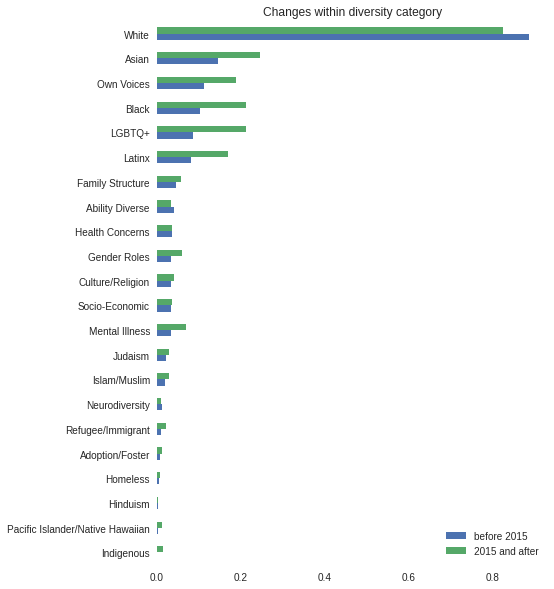

In [46]:
cutoff_year = 2015
by_year = audit_df.loc[audit_df['Item Added Year']<cutoff_year,audit_columns].mean(axis=0).to_frame()
by_year.columns = ['before {}'.format(cutoff_year)]
by_year['{} and after'.format(cutoff_year)] = audit_df.loc[audit_df['Item Added Year']>=cutoff_year,audit_columns].mean(axis=0).to_frame()
by_year = by_year.sort_values(by_year.columns[0])
by_year.plot.barh(figsize=(7,10))
plt.legend(loc = 'lower right')
plt.title('Changes within diversity category')
plt.show()

**The average diversity score of newly acquired titles has been rising noticeably in the past five years. Are titles with more diversity categories present circulating more or less? We'll need to account for the fact that the "Total Charges" data is over the lifetime of the title's inclusion in the selection. Older titles will have had more time to circulate, after all. Unfortunately, this metric will suffer from survivorship bias, as items with poor circulation are more likely to be removed from the collection.**

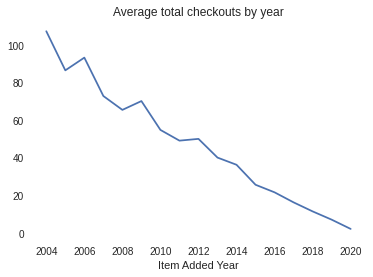

In [47]:
# removing 1997, since there's just a single entry
audit_df[audit_df['Item Added Year']>1998].groupby('Item Added Year')['Total Charges'].mean().plot()
plt.title('Average total checkouts by year')
plt.show()

**Below we can see the 'survivorship bias' mentioned above. Older titles that have been retained in the collection are on average less diverse, but have circulated more.**

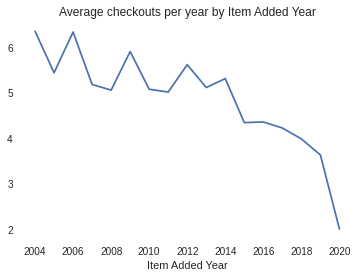

In [48]:
from datetime import datetime
audit_df['Years in Collection'] = audit_df['Item Created Date'].apply(lambda x: (datetime.today() - x).days / 365.0)
audit_df['Charges per year'] = audit_df['Total Charges'] / (audit_df['Years in Collection'])
audit_df[audit_df['Item Added Year']>1998].groupby('Item Added Year')['Charges per year'].mean().plot()
plt.title('Average checkouts per year by Item Added Year')
plt.ylabel('')
plt.show()

**If we look at average number of checkouts per year relative to the diversity score, we can see that accounting for the age of the item has removed much of the variability in the number of checkouts.**

Text(0.5, 1.0, 'Average checkouts per year by Item Added Year')

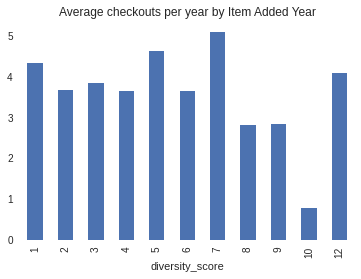

In [49]:
audit_df[audit_df['Item Added Year']>1998].groupby('diversity_score')['Charges per year'].mean().plot.bar()
plt.title('Average checkouts per year by Item Added Year')

**We can also try to account for the survivorship bias by running a linear regression analysis on the data. This should help us understand how the age and diversity score of an item impact the number of total checkouts for that item.**

In [50]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg_data = audit_df[['Years in Collection','diversity_score','Charges per year']].dropna(how='any', axis=0).values
X = linreg_data[:,[0,1]]
y = linreg_data[:,2]

linreg.fit(X,y)
age_coef, diversity_coef = linreg.coef_

print("age factor = {:.3f}".format(age_coef))
print("diversity factor = {:.3f}".format(diversity_coef))

age factor = 0.273
diversity factor = 0.057


**The two values shown above are estimates of how the popularity of a work changes relative to the length of time an item has been in the collection and the number of diversity categories a work contains. What we see is that the older items in the collection have circulated more on average (hence their continued inclusion) and that works with larger numbers of diversity categories present do not necessarily circulate more or less than titles with fewer categories represented.**